### Keeping Track of Accuracies

#### PixelHop++  (TH1=0.005)
##### MNIST
TH2 = 0.001 : Train - 98.535 , Test - 96.57 <br>
TH2 = 0.005 : Train - 93.92 , Test - 90.76 <br>
TH2 = 0.01 : Train - 88.75 , Test - 84.52
##### FashionMNIST
TH2 = 0.001 : Train - 90.835 , Test - 85.84 <br>
TH2 = 0.005 : Train - 85.56 , Test - 80.91 <br>
TH2 = 0.01 : Train - 80.34 , Test - 76.13


#### PixelHop Base (TH1=0.005)
##### MNIST
TH2 = 0.001 : Train - 98.803 , Test - 96.43 <br>
TH2 = 0.005 : Train - 97.47, Test - 95.38 <br>
TH2 = 0.01 : Train - 96.63 , Test - 94.64
##### FashionMNIST
TH2 = 0.001 : Train - 91.113 , Test - 86.0 <br>
TH2 = 0.005 : Train - 87.00, Test - 82.98<br>
TH2 = 0.01 : Train - 84.18 , Test - 80.46

In [123]:
import numpy as np
TH2_list = np.array([0.001, 0.005, 0.01])
plus_mnist_train = np.array([98.535, 93.92, 88.75])
plus_mnist_test = np.array([96.57, 90.76, 84.52])
plus_fmnist_train = np.array([90.835, 85.56, 80.34])
plus_fmnist_test = np.array([85.84, 80.91, 76.13])

base_mnist_train = np.array([98.803, 97.47, 96.63])
base_mnist_test = np.array([96.43, 95.38, 94.64])
base_fmnist_train = np.array([91.113, 87.00, 84.18])
base_fmnist_test = np.array([86.00, 82.98, 80.46])

In [124]:
from tensorflow.keras.datasets import mnist,fashion_mnist
from skimage.util import view_as_windows
from pixelhop import Pixelhop
from skimage.measure import block_reduce
import xgboost as xgb
import warnings, gc
from sklearn.metrics import confusion_matrix, accuracy_score
# suppress warnings
warnings.filterwarnings("ignore")
import time

#### Dataset Size Parameters

In [125]:
np.random.seed(1)

# Preprocess
N_Train_Reduced = 10000    # 10000
N_Train_Full = 60000     # 50000
N_Test = 10000            # 10000

BS = 2000 # batch size

In [126]:
def shuffle_data(X, y):
    shuffle_idx = np.random.permutation(y.size)
    X = X[shuffle_idx]
    y = y[shuffle_idx]
    return X, y

In [127]:
def select_balanced_subset(images, labels, use_num_images):
    '''
    select equal number of images from each classes
    '''
    num_total, H, W, C = images.shape
    num_class = np.unique(labels).size
    num_per_class = int(use_num_images / num_class)

    # Shuffle
    images, labels = shuffle_data(images, labels)

    selected_images = np.zeros((use_num_images, H, W, C))
    selected_labels = np.zeros(use_num_images)

    for i in range(num_class):
        selected_images[i * num_per_class:(i + 1) * num_per_class] = images[labels == i][:num_per_class]
        selected_labels[i * num_per_class:(i + 1) * num_per_class] = np.ones((num_per_class)) * i

    # Shuffle again
    selected_images, selected_labels = shuffle_data(selected_images, selected_labels)

    return selected_images, selected_labels

In [128]:
def Shrink(X, shrinkArg):
    #---- max pooling----
    pool = shrinkArg['pool']
    # Make two different things (if pool is True or if pool is False)
    # if False do nothing, if True, do 2x2 max-pooling
    out = X
    if pool is False:
        pass
    elif pool is True:
        N, H, W, C = X.shape
        pool_height, pool_width = 2, 2
        stride = 2
        x_reshaped = X.reshape(N, H // pool_height, pool_height,
                            W // pool_width, pool_width, C)
        out = x_reshaped.max(axis=2).max(axis=3)

    #---- neighborhood construction
    win = shrinkArg['win']
    stride = shrinkArg['stride']
    pad = shrinkArg['pad']
    ch = X.shape[-1]

    # code from discussion
    # pad
    if pad > 0:
        out = np.pad(out,((0,0), (pad,pad), (pad,pad), (0,0)), 'reflect')

    # neighborhood construction
    out = view_as_windows(out, (1,win,win,ch), (1,stride,stride,ch))

    # return array
    #print((out.reshape(out.shape[0], out.shape[1], out.shape[2], -1)).shape)
    return out.reshape(out.shape[0], out.shape[1], out.shape[2], -1)

In [129]:
# example callback function for how to concate features from different hops
def Concat(X, concatArg):
    return X

def get_feat(X, p2, num_layers=3):
    output = p2.transform_singleHop(X,layer=0)
    if num_layers>1:
        for i in range(num_layers-1):
            output = p2.transform_singleHop(output, layer=i+1)
    return output

In [130]:
def reshape_feats(train_feats, test_feats):
    N_train, _, _, X_train = train_feats.shape
    N_test, _, _, X_test = test_feats.shape
    train = np.reshape(train_feats, (N_train, X_train))
    test = np.reshape(test_feats, (N_test, X_test))
    
    return train, test

### Main

#### Define the dataset to use

In [143]:
dataset = 'fashion-mnist'

In [144]:
# ---------- Load MNIST data and split ----------
if dataset == 'mnist':
    (x_train, y_train), (x_test,y_test) = mnist.load_data()
elif dataset == 'fashion-mnist':
    (x_train, y_train), (x_test,y_test) = fashion_mnist.load_data()


# -----------Data Preprocessing-----------
x_train = np.asarray(x_train,dtype='float32')[:,:,:,np.newaxis]
x_test = np.asarray(x_test,dtype='float32')[:,:,:,np.newaxis]
y_train = np.asarray(y_train,dtype='int')
y_test = np.asarray(y_test,dtype='int')

# if use only 10000 images train pixelhop
x_train_reduced, y_train_reduced = select_balanced_subset(x_train, y_train, use_num_images=N_Train_Reduced)

x_train /= 255.0
x_test /= 255.0
    
    

#### Change TH2 value

In [145]:
thresh2 = 0.001

### Module 1

In [146]:
print('Running Module 1...')
# -----------Module 1: set PixelHop parameters-----------
# PixelHop++ parameteers
# Setup the Shrink Arguments
shrinkArgs = [{'func':Shrink, 'win':5, 'stride':1, 'pad':2, 'pool':False},
               {'func':Shrink, 'win':5, 'stride':1, 'pad':0, 'pool':True},
               {'func':Shrink, 'win':5, 'stride':1, 'pad':0, 'pool':True}]
# Setup the Saab Arguments for PixelHop++
SaabArgs_plus = [{'num_AC_kernels':-1, 'needBias':False, 'cw':False},
            {'num_AC_kernels':-1, 'needBias':True, 'cw':True},
            {'num_AC_kernels':-1, 'needBias':True, 'cw':True}]
# Setup the Saab Arguments for PixelHop
SaabArgs_base = [{'num_AC_kernels':-1, 'needBias':False, 'cw':False},
            {'num_AC_kernels':-1, 'needBias':True, 'cw':False},
            {'num_AC_kernels':-1, 'needBias':True, 'cw':False}]
# Setup Concat Arguments
concatArg = {'func':Concat}


# -----------Module 1: Train PixelHop -----------
# Construct PixelHop++ model
p2_plus = Pixelhop(depth=3, TH1=0.005, TH2=thresh2, 
              SaabArgs=SaabArgs_plus, shrinkArgs=shrinkArgs, concatArg=concatArg)

# Construct the PixelHop model
p2_base = Pixelhop(depth=3, TH1=0.005, TH2=thresh2, 
              SaabArgs=SaabArgs_base, shrinkArgs=shrinkArgs, concatArg=concatArg)

# Train PixelHop++ on the reduced subset
print('Training PixelHop++ model...')
p2_plus.fit(x_train_reduced)
print('Done. \nTraining PixelHop model...')
p2_base.fit(x_train_reduced)
print('Done.')

Running Module 1...
Training PixelHop++ model...
=============================================>c/w Saab Train Hop 1
=============================================>c/w Saab Train Hop 2
=============================================>c/w Saab Train Hop 3
Done. 
Training PixelHop model...
=============================================>c/w Saab Train Hop 1
=============================================>c/w Saab Train Hop 2
=============================================>c/w Saab Train Hop 3
Done.


## Module 2

In [135]:
print('Running Module 2...')
# --------- Module 2: get only Hop 3 feature for both training set and testing set -----------
# you can get feature "batch wise" and concatenate them if your memory is restricted
print('Getting the hop3 features for PixelHop++')
train_hop3_feats_plus = get_feat(x_train, p2_plus)
test_hop3_feats_plus = get_feat(x_test, p2_plus)
print('Getting the hop3 features for PixelHop')
train_hop3_feats_base = get_feat(x_train, p2_base)
test_hop3_feats_base = get_feat(x_test, p2_base)

Running Module 2...
Getting the hop3 features for PixelHop++
Getting the hop3 features for PixelHop


In [136]:
# --------- Module 2: standardization
STD_plus = np.std(train_hop3_feats_plus, axis=0, keepdims=1)
STD_base = np.std(train_hop3_feats_base, axis=0, keepdims=1)
train_hop3_feats_plus = train_hop3_feats_plus/STD_plus
test_hop3_feats_plus = test_hop3_feats_plus/STD_plus
train_hop3_feats_base = train_hop3_feats_base/STD_base
test_hop3_feats_base = test_hop3_feats_base/STD_base

In [137]:
print(train_hop3_feats_plus.shape)
print(test_hop3_feats_plus.shape)
print(train_hop3_feats_base.shape)
print(test_hop3_feats_base.shape)

(60000, 1, 1, 128)
(10000, 1, 1, 128)
(60000, 1, 1, 69)
(10000, 1, 1, 69)


##### Reshape the features

In [138]:
train_plus_reshaped, test_plus_reshaped = reshape_feats(train_hop3_feats_plus, test_hop3_feats_plus)
train_base_reshaped, test_base_reshaped = reshape_feats(train_hop3_feats_base, test_hop3_feats_base)

In [139]:
print(train_plus_reshaped.shape)
print(test_plus_reshaped.shape)
print(train_base_reshaped.shape)
print(test_base_reshaped.shape)

(60000, 128)
(10000, 128)
(60000, 69)
(10000, 69)


## Module 3

In [107]:
print('Running Module 3...')
#---------- Module 3: Train XGBoost classifier on hop3 feature ---------

clf_plus = xgb.XGBClassifier(n_jobs=-1,
                    objective='multi:softprob',
                    # tree_method='gpu_hist', gpu_id=None,
                    max_depth=6,n_estimators=100,
                    min_child_weight=5,gamma=5,
                    subsample=0.8,learning_rate=0.1,
                    nthread=8,colsample_bytree=1.0)

clf_base = xgb.XGBClassifier(n_jobs=-1,
                    objective='multi:softprob',
                    # tree_method='gpu_hist', gpu_id=None,
                    max_depth=6,n_estimators=100,
                    min_child_weight=5,gamma=5,
                    subsample=0.8,learning_rate=0.1,
                    nthread=8,colsample_bytree=1.0)

# fit the classifier to the reshaped training data
print('Fitting xgboost on PixelHop++...')
clf_plus.fit(train_plus_reshaped, y_train)
print('Done. \nFitting xgboost on PixelHop...')
clf_base.fit(train_base_reshaped, y_train)
print('Done.')

Running Module 3...
Fitting xgboost on PixelHop++...
[00:32:56] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Done. 
Fitting xgboost on PixelHop...
[00:34:16] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Done.


In [108]:
# get accuracy on test dataset
print('Getting accuracy of PixelHop++...')
pred_test_plus = clf_plus.predict(test_plus_reshaped)
pred_train_plus = clf_plus.predict(train_plus_reshaped)
acc_train_plus = accuracy_score(y_train, pred_train_plus)
acc_test_plus = accuracy_score(y_test, pred_test_plus)
print(f'The testing accuracy is : {acc_test_plus*100}')
print(f'The training accuracy is : {acc_train_plus*100}')
print('\nGetting accuracy of PixelHop...')
pred_test_base = clf_base.predict(test_base_reshaped)
pred_train_base = clf_base.predict(train_base_reshaped)
acc_train_base = accuracy_score(y_train, pred_train_base)
acc_test_base = accuracy_score(y_test, pred_test_base)
print(f'The testing accuracy of using is : {acc_test_base*100}')
print(f'The training accuracy is : {acc_train_base*100}')

Getting accuracy of PixelHop++...
The testing accuracy is : 76.13
The training accuracy is : 80.34166666666667

Getting accuracy of PixelHop...
The testing accuracy of using is : 80.46
The training accuracy is : 84.18333333333334


<br>
<br>
<br>

### Finding Model Size for PixelHop and PixelHop++

In [147]:
def find_model_size(p2, plus):
    num_param = 0
    
    # run get_feat to get K1, K2, and K3
    # get K1
    print('Getting the number of K1 features...')
    feats = get_feat(x_train, p2, num_layers=0)
    _, _, _, K1 = feats.shape
    print('Done.')

    # get K2
    print('Getting the number of K2 features...')
    feats = get_feat(x_train, p2, num_layers=2)
    _, _, _, K2 = feats.shape
    print('Done.')

    # get k3
    print('Getting the number of K3 features...')
    feats = get_feat(x_train, p2, num_layers=3)
    _, _, _, K3 = feats.shape
    print('Done.')
    
    # check if we're finding model size for PixelHop++
    if plus is True:
        num_param = (K1+K2+K3)*25
    else:
        num_param = (5*5*K1 + K1*5*5*K2 + K2*5*5*K3)
    
    return num_param

In [148]:
model_size_plus = find_model_size(p2=p2_plus, plus=True)
model_size_base = find_model_size(p2=p2_base, plus=False)

Getting the number of K1 features...
Done.
Getting the number of K2 features...
Done.
Getting the number of K3 features...
Done.
Getting the number of K1 features...
Done.
Getting the number of K2 features...
Done.
Getting the number of K3 features...
Done.


In [149]:
print(f'The model size of PixelHop++ is: {model_size_plus}')
print(f'The model size of PixelHop is: {model_size_base}')

The model size of PixelHop++ is: 3800
The model size of PixelHop is: 74275


<br>
<br>
<br>

### Plotting TH2 vs train and test accuracies for PixelHop and PixelHop++

#### TH2 vs. MNIST

In [111]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'TH2 vs MNIST Accuracy')

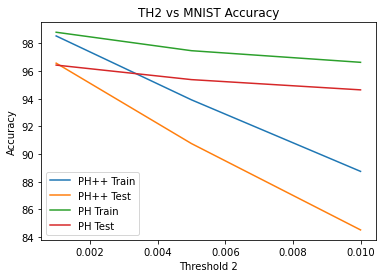

In [119]:
plt.plot(TH2_list, plus_mnist_train)
plt.plot(TH2_list, plus_mnist_test)
plt.plot(TH2_list, base_mnist_train)
plt.plot(TH2_list, base_mnist_test)
plt.legend(['PH++ Train', 'PH++ Test', 'PH Train', 'PH Test'])
plt.ylabel('Accuracy')
plt.xlabel('Threshold 2')
plt.title('TH2 vs MNIST Accuracy')

#### TH2 vs Fashion-MNIST

Text(0.5, 1.0, 'TH2 vs Fashion-MNIST Accuracy')

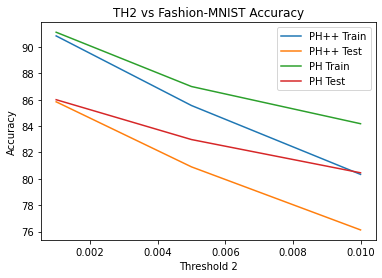

In [120]:
plt.plot(TH2_list, plus_fmnist_train)
plt.plot(TH2_list, plus_fmnist_test)
plt.plot(TH2_list, base_fmnist_train)
plt.plot(TH2_list, base_fmnist_test)
plt.legend(['PH++ Train', 'PH++ Test', 'PH Train', 'PH Test'])
plt.ylabel('Accuracy')
plt.xlabel('Threshold 2')
plt.title('TH2 vs Fashion-MNIST Accuracy')

<br>
<br>
<br>